In [1]:
# !pip install pandas numpy
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np

# !pip install sklearn
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
train = pd.read_csv("../../data/Train.csv", sep=",")
metadata = pd.read_csv("../../data/metadata.csv", sep=",")
test = pd.read_csv("../../data/Test.csv", sep=",")

/home/nikhil/.local/share/virtualenvs/zindi_paygo-MEN1gcQP/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train_merged = metadata.merge(train[['ID', 'TransactionDates', 'PaymentsHistory',
                      'm1', 'm2', 'm3', 'm4', 'm5', 'm6']], how="right", on="ID")

### Payment Related features

In [5]:
from utils import split, length_calc, sum_calc, mean_calc, median_calc, max_calc, min_calc, std_dev_calc, back_feature
def feature_construction(df):
    try:
        df["SplitPaymentsHistory"] = df.apply(lambda row: split(row["PaymentsHistory"]), axis=1)
        df["SplitTransactionDates"] = df.apply(lambda row: split(row["TransactionDates"]), axis=1)
        df["nb_payments"] = df.apply(lambda row: length_calc(row["SplitPaymentsHistory"]), axis=1)
        df["amount_paid"] = df.apply(lambda row: sum_calc(row["SplitPaymentsHistory"]), axis=1)
        df["percent_amt_paid"] = df["amount_paid"] / train_merged["TotalContractValue"]
        df["mean_amt_paid"] = df.apply(lambda row: mean_calc(row["SplitPaymentsHistory"]), axis=1)
        df["median_amt_paid"] = df.apply(lambda row: median_calc(row["SplitPaymentsHistory"]), axis=1)
        df["max_amt_paid"] = df.apply(lambda row: max_calc(row["SplitPaymentsHistory"]), axis=1)
        df["min_amt_paid"] = df.apply(lambda row: min_calc(row["SplitPaymentsHistory"]), axis=1)
        df["stddev_amt_paid"] = df.apply(lambda row: std_dev_calc(row["SplitPaymentsHistory"]), axis=1)
    except KeyError as e:
        raise Exception("Column Missing")
        
    return df

train_merged = feature_construction(train_merged)

In [6]:
train_merged["SplitTransactionDates"].iloc[0][0].strip("''")

'04-2018'

In [7]:
# from datetime import date, timedelta
# from datetime import datetime

# d = [datetime.strptime(train_merged["SplitTransactionDates"][0][i].replace("'", "").strip(), "%m-%Y") for i in range(len(train_merged["SplitTransactionDates"][0]))]
# date_set = set(d[0] + timedelta(x) for x in range(int(d[-1] - d[0]).days/30.0))
# missing = sorted(date_set - set(d))
# print(missing)

In [8]:
# pd.date_range(start='2013-01', end='2018-05' ).difference(dates_list = [datetime.strptime(date.strip("''").strip(), '%m-%Y').date() for date in train_merged.SplitTransactionDates[0]])

### Back Payment Features

In [9]:
# Add Back Payment Features


def add_back_feature(df, n=1):
    df[f"b{n}"] = df.apply(lambda row: back_feature(row["SplitPaymentsHistory"], n), axis=1)
    return df

train_merged = add_back_feature(train_merged, 1)
train_merged = add_back_feature(train_merged, 2)
train_merged = add_back_feature(train_merged, 3)
train_merged = add_back_feature(train_merged, 4)
train_merged = add_back_feature(train_merged, 5)

In [10]:
train_merged.LastPaymentDate

0        2021-05-26 17:14:45
1        2021-05-26 16:54:53
2        2021-01-25 18:46:20
3        2018-12-20 16:50:39
4        2021-05-12 14:50:01
                ...         
28002    2019-10-11 12:37:41
28003    2021-03-13 14:23:22
28004    2021-03-28 16:01:16
28005    2019-03-20 16:38:09
28006    2018-12-09 12:40:57
Name: LastPaymentDate, Length: 28007, dtype: object

### Date Related Features

TODO: 
1. Skipped payments and duration of skipping payments
2. Check for custom seasonality (Weather changes EDA)

### Backward Feature elimination

1. Take 50% of the data and build the model

In [11]:
train_merged["RegistrationDateParsed"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True)
train_merged["ExpectedTermDateParsed"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True)
train_merged["FirstPaymentDateParsed"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True)
train_merged["LastPaymentDateParsed"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True)

train_merged["RegistrationDate"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True).dt.date
train_merged["ExpectedTermDate"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True).dt.date
train_merged["FirstPaymentDate"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True).dt.date
train_merged["LastPaymentDate"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True).dt.date

In [12]:
train_merged["LastFirstDuration"] = (train_merged.LastPaymentDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["ExpectedFirstDuration"] = (train_merged.ExpectedTermDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["LastRegistrationDuration"] = (train_merged.LastPaymentDate - train_merged.RegistrationDate).astype("timedelta64[M]")

In [13]:
# Months
train_merged["FirstPaymentMonth"] = train_merged["FirstPaymentDateParsed"].dt.month
train_merged["LastPaymentMonth"] = train_merged["LastPaymentDateParsed"].dt.month
train_merged["RegistrationMonth"] = train_merged["RegistrationDateParsed"].dt.month

# Sine
train_merged["FirstPaymentMonthSin"] = np.sin((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
train_merged["LastPaymentMonthSin"] = np.sin((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
train_merged["RegistrationMonthSin"] = np.sin((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

# Cos
train_merged["FirstPaymentMonthCos"] = np.cos((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
train_merged["LastPaymentMonthCos"] = np.cos((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
train_merged["RegistrationMonthCos"] = np.cos((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

In [14]:
train_merged.drop(["RegistrationDateParsed", "ExpectedTermDateParsed", "FirstPaymentDateParsed", "LastPaymentDateParsed"], axis=1, inplace=True)

### We can ignore UpSell since it represents only 2.7% of the rows

In [15]:
train_merged.UpsellDate.count() / train_merged.shape[0] * 100

2.6493376655836043

### Bar Plots

1. Month by Payments
2. Month by Number of Payments
3. Month by 

In [16]:
train_merged.nb_payments.describe()

count    28007.000000
mean        16.262363
std          9.248264
min          5.000000
25%          8.000000
50%         14.000000
75%         23.000000
max         52.000000
Name: nb_payments, dtype: float64

### Drop irrelevant columns

In [17]:
def drop_cols(df):
    df.drop(
        [
            "ID",
            "UpsellDate",
            "PaymentMethod",
            "TransactionDates",
            "PaymentsHistory",
            "SupplierName",
            "Town"
        ],
        inplace=True,
        axis=1
    )
drop_cols(train_merged)

In [18]:
train_merged.head()

,RegistrationDate,Deposit,AccessoryRate,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Occupation,...,LastRegistrationDuration,FirstPaymentMonth,LastPaymentMonth,RegistrationMonth,FirstPaymentMonthSin,LastPaymentMonthSin,RegistrationMonthSin,FirstPaymentMonthCos,LastPaymentMonthCos,RegistrationMonthCos
0,2018-04-23,2500,0.0,DAILY,55,3,Male,NaN,Coast Region,Teacher,...,37.0,4,5,4,1.000000,0.866025,1.000000,6.123234e-17,-0.500000,6.123234e-17
1,2018-04-17,2500,0.0,DAILY,55,3,Male,26.0,South Rift,Farmer,...,37.0,4,5,4,1.000000,0.866025,1.000000,6.123234e-17,-0.500000,6.123234e-17
2,2020-02-18,2400,0.0,DAILY,50,3,Male,21.0,Mount Kenya Region,Business,...,11.0,2,1,2,0.500000,0.000000,0.500000,8.660254e-01,1.000000,8.660254e-01
3,2017-09-14,2000,0.0,DAILY,40,7,Female,26.0,Mount Kenya Region,Farmer,...,15.0,9,12,9,-0.866025,-0.500000,-0.866025,-5.000000e-01,0.866025,-5.000000e-01
4,2017-09-06,2000,0.0,DAILY,40,7,Male,27.0,North Rift,Farmer,...,44.0,9,5,9,-0.866025,0.866025,-0.866025,-5.000000e-01,-0.500000,-5.000000e-01


### Feature Encoding

In [19]:
# OHE

def encode_and_bind(df, feature_name):
    dummies = pd.get_dummies(df[[feature_name]])
    res = pd.concat([df, dummies], axis=1)
    res = res.drop([feature_name], axis=1)
    return(res)

for feature in ["MainApplicantGender", "Region", "Occupation", "rateTypeEntity"]:
    train_merged = encode_and_bind(train_merged, feature)

In [20]:
train_merged.head()

,RegistrationDate,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,...,Occupation_Business,Occupation_Driver/Motorbike Rider,Occupation_Farmer,Occupation_Government Employee,Occupation_Labourer,Occupation_Other,Occupation_Teacher,rateTypeEntity_DAILY,rateTypeEntity_MONTHLY,rateTypeEntity_WEEKLY
0,2018-04-23,2500,0.0,55,3,NaN,556,33080.0,2019-10-31,2018-04-23,...,0,0,0,0,0,0,1,1,0,0
1,2018-04-17,2500,0.0,55,3,26.0,556,33080.0,2019-10-25,2018-04-17,...,0,0,1,0,0,0,0,1,0,0
2,2020-02-18,2400,0.0,50,3,21.0,240,14400.0,2020-10-15,2020-02-18,...,1,0,0,0,0,0,0,1,0,0
3,2017-09-14,2000,0.0,40,7,26.0,364,16560.0,2018-09-13,2017-09-14,...,0,0,1,0,0,0,0,1,0,0
4,2017-09-06,2000,0.0,40,7,27.0,364,16560.0,2018-09-05,2017-09-06,...,0,0,1,0,0,0,0,1,0,0


In [21]:
train_merged.drop(["RegistrationDate", "ExpectedTermDate", "FirstPaymentDate", "LastPaymentDate", "SplitPaymentsHistory", "SplitTransactionDates", "m2", "m3", "m4", "m5", "m6"], inplace=True, axis=1)


### Data Leakage here. Will be handled later.

<AxesSubplot:>

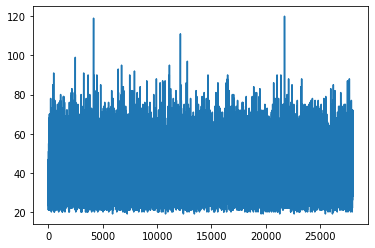

In [25]:
# train_merged.Age.plot()

In [22]:
train_merged.Age = train_merged.Age.fillna(train_merged.Age.mean())

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

np.random.seed(0)
def predict_model(train_array, target):
    model = xgb.XGBRegressor(use_label_encoder=False,
                             verbosity=0,
                             objective="reg:squarederror",
                             reg_lambda=0,
                             reg_alpha=50)
    for i in range(1, 11):
        X_train, X_test, y_train, y_test = train_test_split(train_array, target, test_size=0.20)
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    feature_importance = model.feature_importances_
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = pow(mse, 0.5)

    return y_pred, mape, mse, feature_importance, rmse

predict_model(train_merged.drop(["m1"], axis=1), train_merged["m1"])

(array([ 255.65474,  917.0565 ,  297.1074 , ..., 1207.4072 ,  929.06165,
         406.2758 ], dtype=float32),
 0.979776760730671,
 185524.68208459264,
 array([0.0247818 , 0.07518963, 0.01137567, 0.00420607, 0.05192063,
        0.01716595, 0.06637507, 0.05616232, 0.03606681, 0.02436592,
        0.04456397, 0.05648439, 0.03724673, 0.00985612, 0.00804755,
        0.21999808, 0.04654755, 0.02861566, 0.0069202 , 0.00862808,
        0.0161342 , 0.        , 0.00592132, 0.00874534, 0.00607938,
        0.        , 0.00553371, 0.01408456, 0.        , 0.00567654,
        0.01156513, 0.        , 0.0049327 , 0.        , 0.00676817,
        0.00741548, 0.00519214, 0.00676522, 0.00519089, 0.00813076,
        0.00320479, 0.00365307, 0.00754813, 0.00317403, 0.0079423 ,
        0.00548868, 0.00413712, 0.01049977, 0.        , 0.        ,
        0.00169833], dtype=float32),
 430.7257620395983)

### Outlier Handling
### Advance Modelling
### EDA for adding time features
### Scaling & Normalization